In [1]:
from datasets import load_dataset
import torch
from diffusers import UNet2DModel

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [2]:
model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=1,
    block_out_channels=(32, 64),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [3]:
model

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, kernel_si

In [13]:
# transform to min-max normalize the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / x.max())
])
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

# train_noisy_dataset = MNISTDataset(train_dataset)
# test_noisy_dataset = MNISTDataset(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
sample_image = train_dataset[0][0].unsqueeze(0)
sample_image.shape

torch.Size([1, 1, 28, 28])

In [15]:
output = model(sample_image, timestep=0).sample

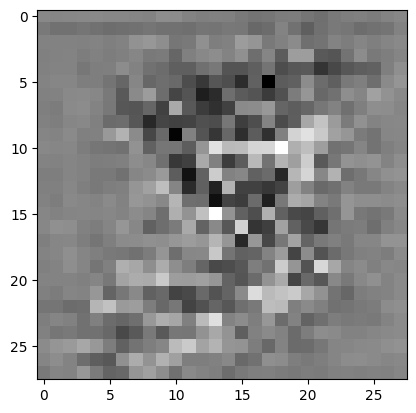

In [16]:
import matplotlib.pyplot as plt

plt.imshow(output.squeeze().detach().numpy(), cmap='gray')

In [17]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=150)

In [18]:
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([20])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

output = model(noisy_image, timestep=50).sample

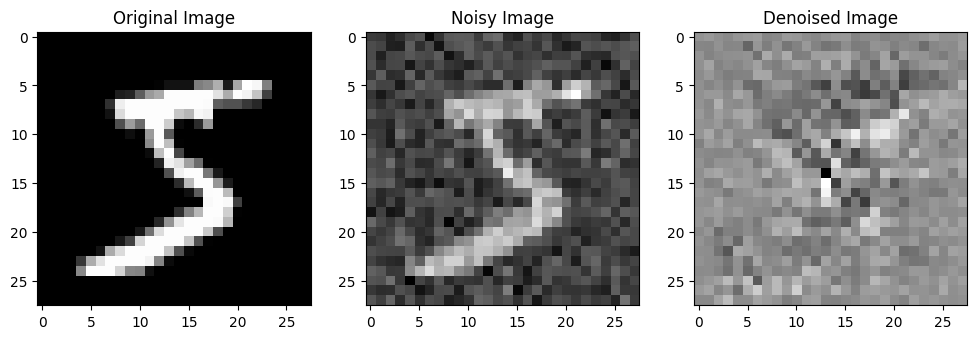

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.imshow(sample_image.squeeze().detach().numpy(), cmap='gray')
ax1.set_title('Original Image')

ax2.imshow(noisy_image.squeeze().detach().numpy(), cmap='gray')
ax2.set_title('Noisy Image')

ax3.imshow(output.squeeze().detach().numpy(), cmap='gray')
ax3.set_title('Denoised Image')

plt.show()

In [20]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.0710, grad_fn=<MseLossBackward0>)


In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [23]:
from diffusers.optimization import get_cosine_schedule_with_warmup

num_train_steps = len(train_loader) * 10
print(num_train_steps)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=50,
    num_training_steps=(num_train_steps),
)

18750


In [24]:
from tqdm import tqdm

for epoch in range(10):
    model.train()
    for i, (clean_images, labels) in tqdm(enumerate(train_loader)):
        noise = torch.randn(clean_images.shape)
        bs = clean_images.shape[0]

        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    
    print(f'Epoch {epoch} Loss: {loss.item()}')


0it [00:00, ?it/s]/usr/local/lib/python3.12/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
1875it [26:23,  1.18it/s]


Epoch 0 Loss: 0.042306363582611084


569it [08:01,  1.18it/s]


KeyboardInterrupt: 

In [90]:
batch = next(iter(train_loader))

In [25]:
from diffusers import DDPMPipeline

In [26]:
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)


In [27]:
images = pipeline(
    batch_size=10,
    generator=torch.manual_seed(42),
    num_inference_steps=150,
).images

100%|██████████| 150/150 [00:05<00:00, 28.16it/s]


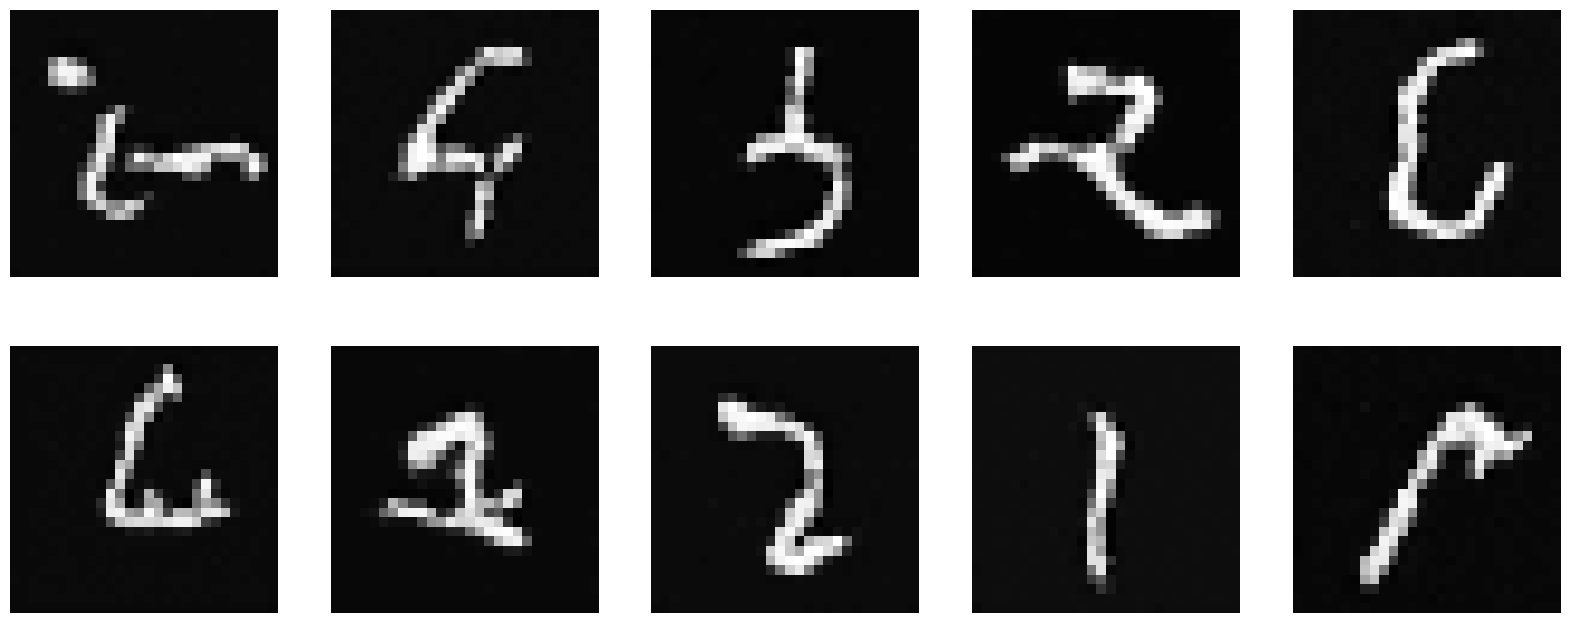

In [28]:
# show images
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax[i // 5, i % 5].imshow(images[i], cmap='gray')
    ax[i // 5, i % 5].axis('off')